In [60]:
# https://github.com/receptor-mammography/receptor-mammography

In [61]:
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from database.dataset import *
from mc_candidate_proposal.hough_mc import HoughCalcificationDetection
from feature_extraction.feature_extraction import CandidatesFeatureExtraction
import feature_extraction.haar_features.haar_modules as hm

from mc_candidate_proposal.candidate_utils import balance_candidates
from general_utils.plots import draw_our_haar_like_features, plot_blobs_2_sets

import time
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [62]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    partitions=['train', 'validation'],
    min_breast_fraction_roi=0.5,
    normalize=None,
    n_jobs=-1,
    use_muscle_mask=True
)

In [63]:
# Candidate Proposals detector
hd = HoughCalcificationDetection(filter_muscle_region=True)

# Feature extractor
haar_params = {
    'skimage': {
        'feature_type': None, 'feature_coord': None
    },
    'ours': {
        'horizontal_feature_types': [(hm.Feature4h, 1, 4), (hm.Feature4v, 4, 1), (hm.Feature3h3v, 3, 3)],
        'rotated_feature_types': None,
        'horizontal_feature_selection': None,
        'rotated_feature_selection': None,
    },
    'patch_size': 14
}
cfe  = CandidatesFeatureExtraction(patch_size=30, fos=False, haar_params=haar_params)

In [64]:
for idx in tqdm(range(len(db))):
    # Get image to process
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    view = db.df.iloc[idx]['view']
    if view != 'MLO':
        continue
    image_mask = db_sample['lesion_mask']
    muscle_mask = db_sample['muscle_mask']

    # candidate detection
    candidates = hd.detect(
        image, image_id, load_processed_images=True, hough2=True, muscle_mask=muscle_mask)[0]

    # labeling of candidates:
    tp, fp, fn = utils.get_tp_fp_fn_center_patch_criteria(
        candidates, image_mask, 14, 14)

    # Balancing the candidates
    tp, fp = balance_candidates(tp, fp, fp2tp_sample=10)

    # Extracting features
    candidates = tp + fp
    labels = np.array([True] * len(tp) + [False] * len(fp))
    
    start = time.time()
    X = cfe.extract_features(np.asarray(candidates), image)
    print(time.time()-start)
    break

  1%|          | 2/167 [00:34<47:28, 17.26s/it]

23.370834589004517


In [82]:
images = utils.get_an_example_array(image, 14, candidates)

In [55]:
from skimage.feature import draw_haar_like_feature

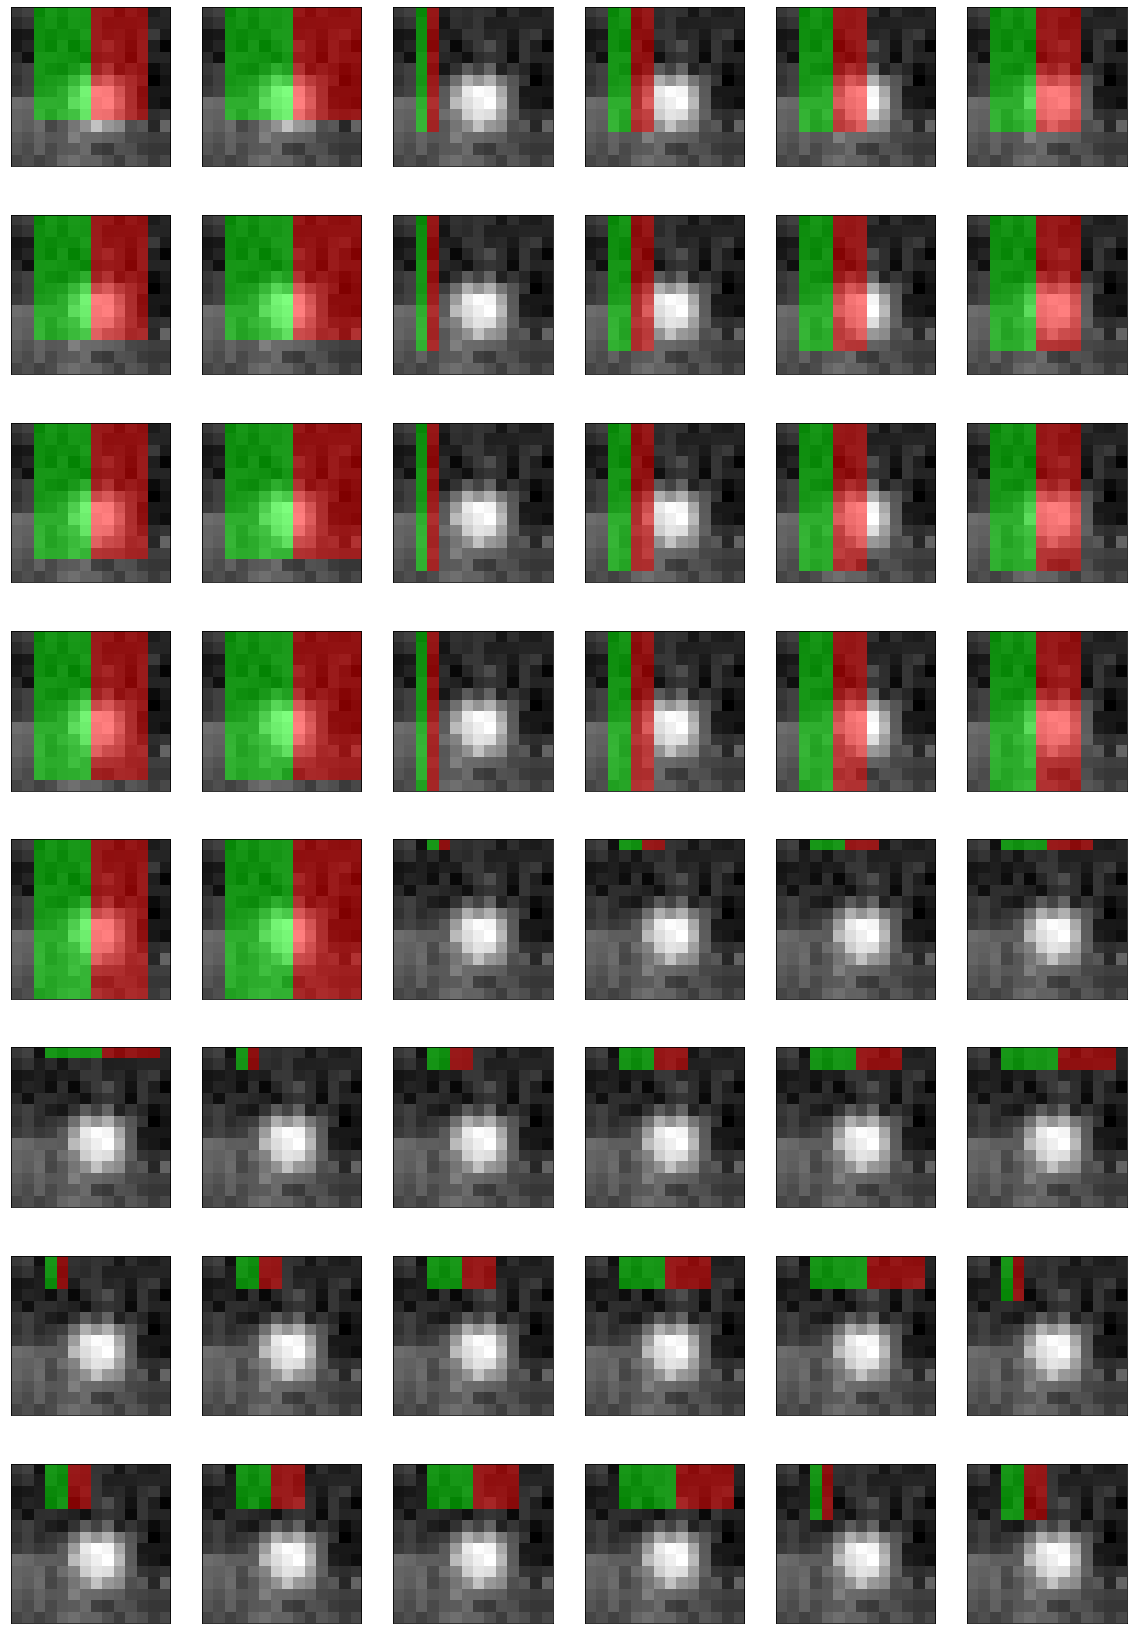

: 

: 

In [87]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for idx, ax in enumerate(axs.ravel()):
    img = utils.min_max_norm(images[0], 1.).astype('float')
    img = draw_haar_like_feature(
        img, 0, 0, images.shape[2], images.shape[1], [cfe.skimage_haar_feature_coords[idx+48*5]])
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

# _ = fig.suptitle('The most important features')

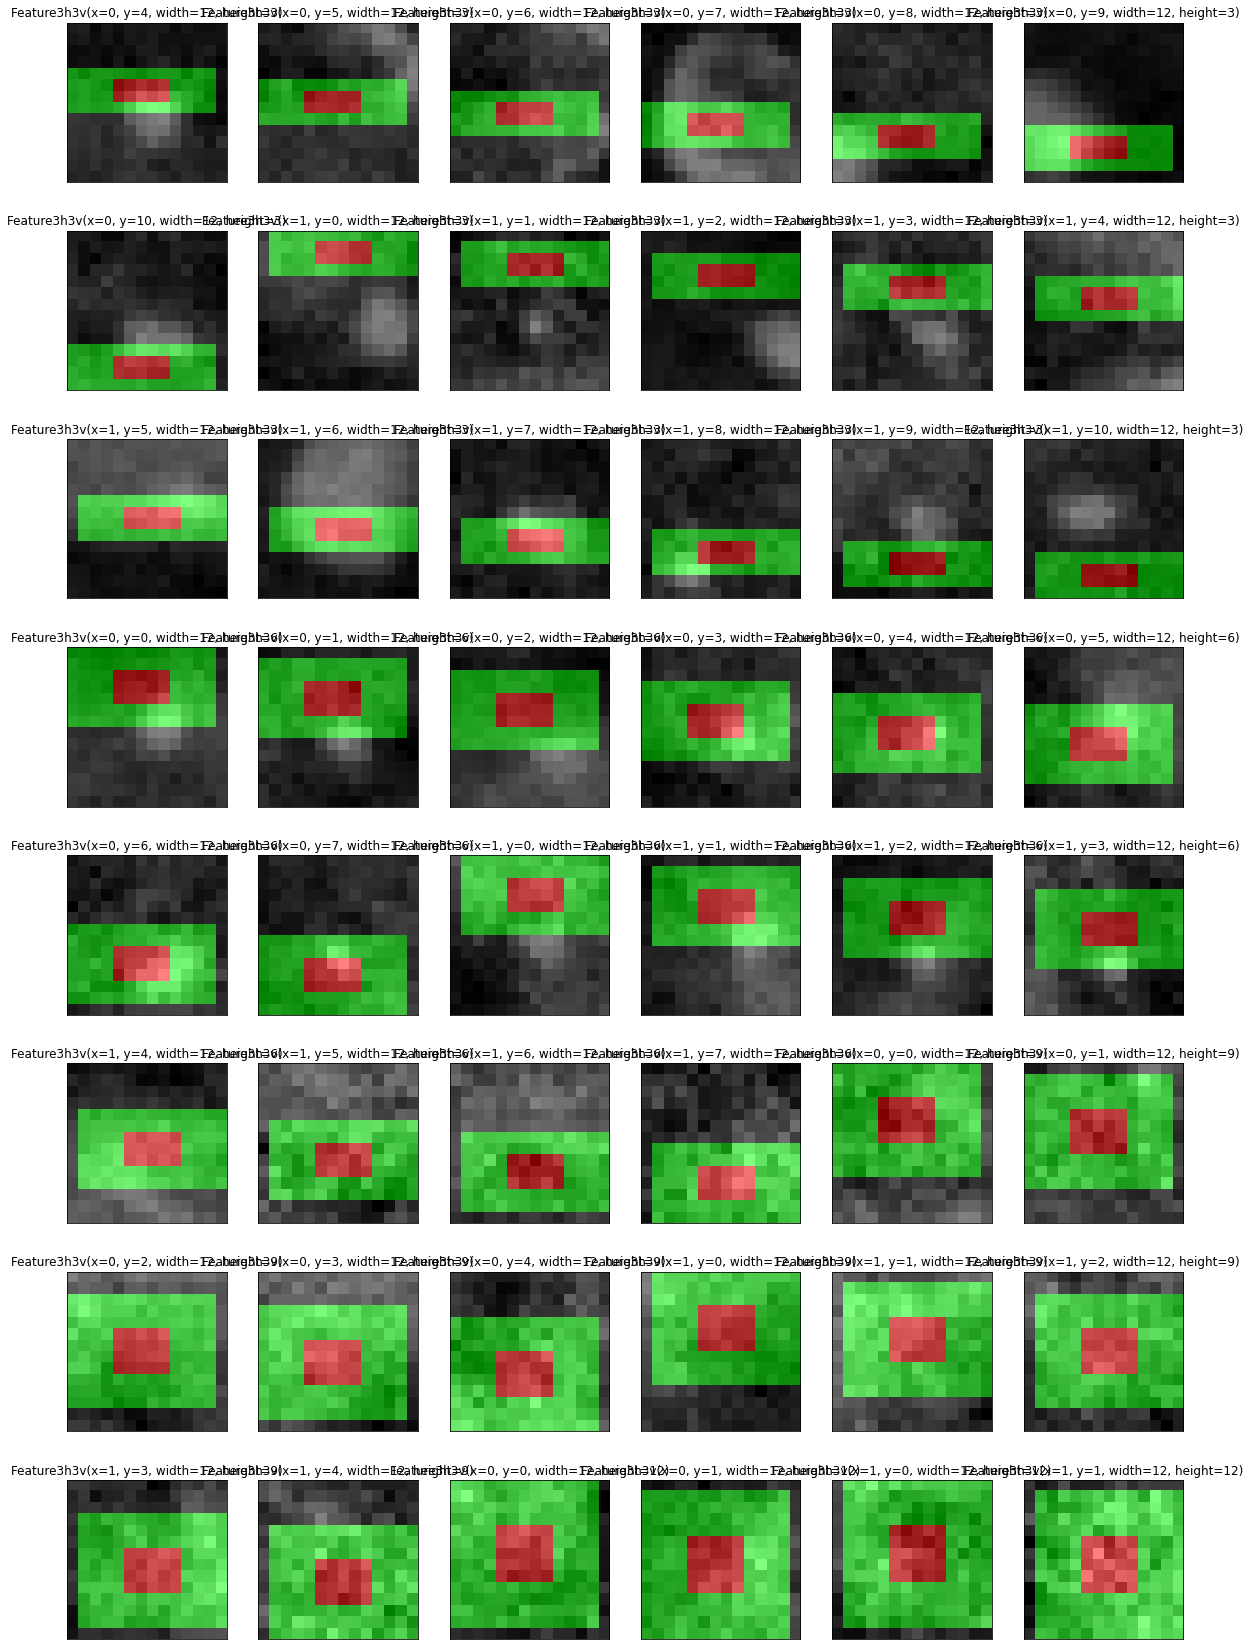

In [31]:
fig, axs = plt.subplots(8, 6, figsize=(20,30))
for ax, img, feat in zip(np.ravel(axs), images, cfe.our_haar_feature_types_h[-48*1:]):
    image = draw_our_haar_like_features(img, feat, rot=False)
    ax.imshow(image)
    ax.set_title(feat)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()